In [60]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite3d_vrel'
run_name = 'nac2'
data_dir = '../data/'+system_name+'/'+run_name+'/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

## Learning of the 3d kite
- The aggregate state are the discretized attack angle and bank angle (values specified in kite.h)
- The wind velocity is constant
- The initial angle with the ground, $\theta$, is constant
- The initial attack angle can be choosen constant or random
- The algortihm is a natural actor-critic with advantage parameters. It uses two power law learning rates (the one of the critic part should be much larger) having a burn-in period in which it stays constant (see the first plot of the learning rates)

In [61]:
# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.0005 # sec
env_params['ep_length'] = 200 # sec
env_params['decision_time'] = 0.05 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
env_params['init_phi'] = 0 # rad
env_params['init_dphi'] = 0 # rad
# attack angles
env_params['alphas'] = [-4, 0, 4, 8, 12, 14, 16, 18, 20]
env_params['CL_alphas'] = [0.05, 0.35, 0.55, 0.75, 0.9, 1.0, 1.08, 1.1, 1.05]
env_params['CD_alphas'] = [0.001, 0.01, 0.03, 0.07, 0.1, 0.13, 0.18, 0.18, 0.21]
env_params['init_alpha'] = len(env_params['alphas'])-1 # index, if larger than len it's random
# bank angles
env_params['banks'] = [-0.1745329, -0.104719755, -0.034906585, 0., 0.034906585, 0.104719755, 0.1745329]
env_params['init_bank'] = int(len(env_params['banks'])/2) # index
# angle of relative velocity (bins)
env_params['beta_bins'] = np.linspace(-np.pi, np.pi, 17)
# wind
env_params['wind_type'] = 'const'
env_params['v_wind_x'] = 10 # m/sec
env_params['v_wind_y'] = 0 # m/sec
env_params['v_wind_z'] = 0 # m/sec

# ALG PARAMETERS
alg_params = dict()
alg_params['alg_type'] = 'nac' # 'ac' for actor-critic, 'nac' for natural actor-critic
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 20000000
print('Dynamical steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Dynamical time, in seconds: ', alg_params['n_steps']*env_params['decision_time'])
alg_params['traj_points'] = 1000

alg_params['init_val_path'] = data_dir + 'init_value.txt' # Value prior, comment for constant values
alg_params['init_pol_path'] = data_dir + 'init_policy.txt' # Policy prior, comment for flat policy
alg_params['init_values'] = env_params['v_wind_x']*env_params['ep_length'] / 5

# Actor learning rate
alg_params['a0'] = 0.01
alg_params['ac'] = 20000
alg_params['a_expn'] = 0.8
alg_params['a_burn'] = 10000000
# Critic learning rate
alg_params['b0'] = 0.00005
alg_params['bc'] = 100000
alg_params['b_expn'] = 0.8
alg_params['b_burn'] = 10000000

Dynamical steps:  2000000000.0
Dynamical time, in seconds:  1000000.0


In [62]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir, 'param_env.txt')
ut.write_params(alg_params, data_dir, 'param_alg.txt')

In [37]:
# COMPILING C++ SCRIPT
comp_list = np.array(["g++", "-o", "train.exe", "train.cpp", "../lib/nac.cpp", "../lib/utils.cpp", "../lib/wind.cpp", 
                      "../lib/envs/kite.cpp", "../lib/envs/kite2d.cpp", "../lib/envs/kite3d.cpp", "-std=c++17"])
comp_str = ""
for s in comp_list: comp_str+=s+" "
print('To compile from terminal: ')
print(comp_str)

To compile from terminal: 
g++ -o train.exe train.cpp ../lib/nac.cpp ../lib/utils.cpp ../lib/wind.cpp ../lib/envs/kite.cpp ../lib/envs/kite2d.cpp ../lib/envs/kite3d.cpp -std=c++17 


In [38]:
# EXECUTING THE SCRIPT
# Acually it doesn't print the standard output on-line. If you want the percentage execute from shell
#p = subprocess.Popen(["./train.exe", system_name, run_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#print(p.stderr.read().decode('utf-8'))
#print(p.stdout.read().decode('utf-8'))

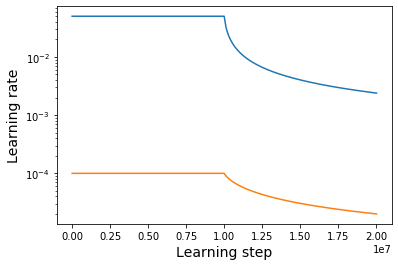

In [43]:
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Learning rate', fontsize=14)
plt.yscale('log')
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
crit_lr = [ut.p_law_burn(x, alg_params['a_burn'], alg_params['a_expn'], alg_params['a0'], alg_params['ac']) for x in xs]
act_lr = [ut.p_law_burn(x, alg_params['b_burn'], alg_params['b_expn'], alg_params['b0'], alg_params['bc']) for x in xs]

plt.plot(xs, crit_lr)
plt.plot(xs, act_lr)

plt.savefig(plot_dir+'lr.png', dpi=200)

In [40]:
import numpy as np
#v_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/value_traj.txt', dtype='float')
v_traj, s_labels = ut.read_traj(data_dir + 'value_traj.txt')
r_traj = np.loadtxt(data_dir + '/return_traj.txt', dtype='float')

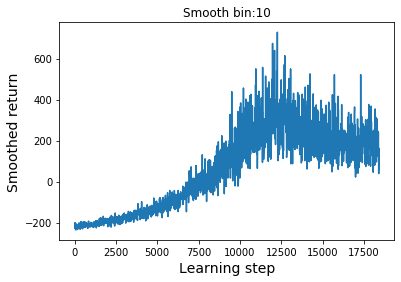

In [47]:
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Smoothed return', fontsize=14)
smooth_bin = 10
plt.title('Smooth bin:'+str(smooth_bin))
x, y = ut.smooth_traj(r_traj, smooth_bin)
plt.plot(x,y)

plt.savefig(plot_dir+'return.png', dpi=200)

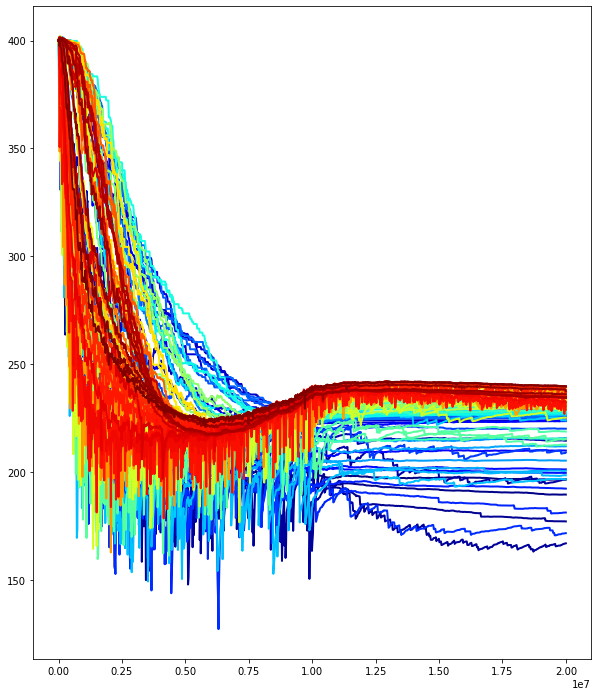

In [57]:
n_alphas=len(env_params['alphas'])
n_banks=len(env_params['banks'])
n_betas=len(env_params['beta_bins'])-1
alpha = n_alphas-1
banks = np.arange(n_banks)
betas = np.arange(n_betas)

colors = plt.cm.jet(np.linspace(0,1,len(banks)*len(betas)))
plt.figure(figsize=(10,12))
count=0

for p in banks:
    for b in betas:
        index = b+n_betas*(p+n_banks*alpha)
        plt.plot(xs, v_traj[:,index], lw=2, label=s_labels[index], c=colors[count])
        count+=1
    
#plt.legend(loc=0)
plt.savefig(plot_dir+'value_a='+str(alpha)+'.png', dpi=200)

In [56]:
p_traj, s_labels, a_labels = ut.read_policy(data_dir + '/' + "policy_traj.txt")

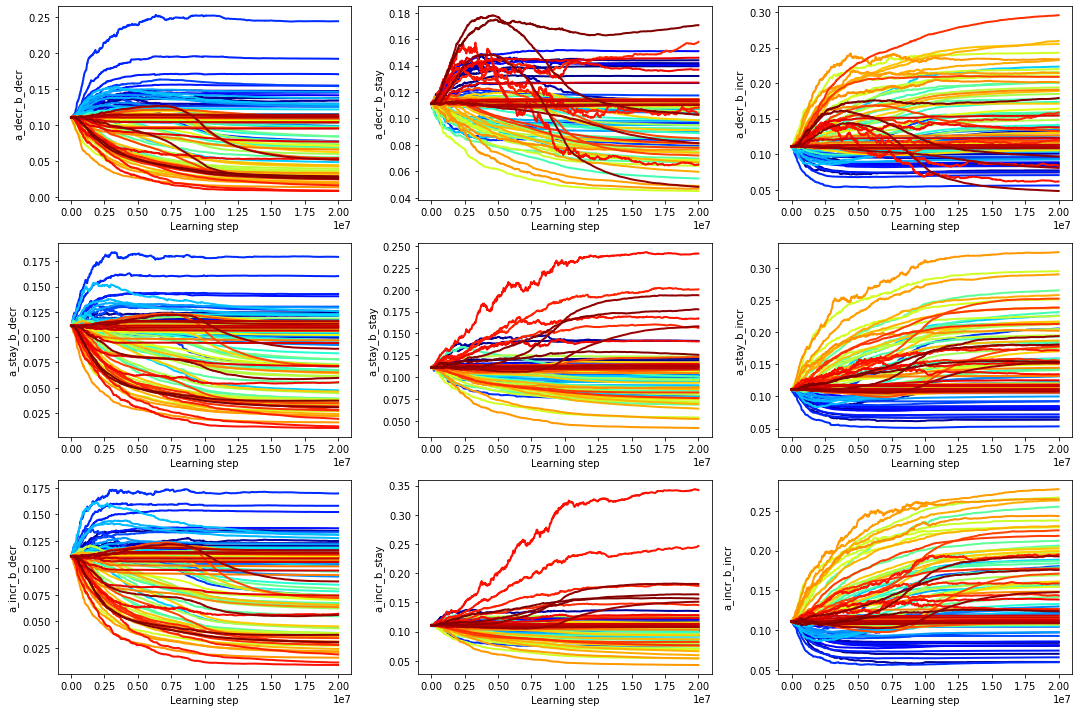

In [59]:
fig, axs = plt.subplots(3,3, figsize=(15,10))
colors = plt.cm.jet(np.linspace(0,1,len(betas)*len(banks)))
states = range(0,len(p_traj[0]))
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )

for a_ind in range(3):
    for b_ind in range(3):
        pl_ind = b_ind + 3*a_ind
        axs[a_ind][b_ind].set_xlabel('Learning step')
        axs[a_ind][b_ind].set_ylabel(a_labels[pl_ind])
        #ax1.set_xlim([0,alg_params['n_steps']])
        #ax1.set_ylim([-100,alg_params['init_values']])
        count=0
        for p in banks:
            for b in betas:
                index = b+n_betas*(p+n_banks*alpha)
                axs[a_ind][b_ind].plot(xs, p_traj[:,index,pl_ind], c=colors[count], lw=2)
                count += 1
                
plt.tight_layout()
plt.savefig(plot_dir+'policy_a='+str(alpha)+'.png', dpi=200)